![logo](../img/LogoLine_horizon_C3S.png)

# Calculation of global climatology and relative anomalies of Surface Radiation Budget from EUMETSAT's CM SAF CLARA-A3 dataset

This notebook provides you with an introduction on EUMETSAT's CM SAF **CLARA-A3** dataset available at the [Climate Data Store](https://cds.climate.copernicus.eu/#!/home) (CDS). The dataset contains data for Essential Climate Variables (ECVs) _Surface Radiation Budget_, as well as _Cloud Properties and Earth Radiation Budget_, while this notebook focuses on **Surface Radiation Budget** as part of the ECV _Surface Radiation Budget_ available here: [Surface radiation budget from 1979 to present derived from satellite observations](https://cds.climate.copernicus.eu/datasets/satellite-surface-radiation-budget?tab=overview).

The notebook covers the full process from scratch and starts with a short introdution to the dataset and how to access the data from the Climate Data Store of the Copernicus Climate Change Service (C3S). This is followed by a step-by-step guide on how to process and visualize the data. Once you feel comfortable with the python code, you are invited to adjust or extend the code according to your interests. After a short introduction how to use a Jupyter notebook the analysis starts.<br>
Two figures below are results of Use Case 1 and 2, and the result of a successful run of the code.

![logo](./images/srb-climatology-and-anomaly-banner.png)

The notebook has two main use cases with the following outline:

## Table of Contents

* [Introduction](#introduction)
* [Prerequisites and data acquisition](#data)
* [Use Cases](#usecases)
    * [Use case 1: The mean global Surface Incoming Shortwave (SIS) radiation distribution](#uc1)
    * [Use case 2: Relative Anomaly. Hot summer of the year 2003 in Europe](#uc2)
* [Get more information about Surface Radiation Budget](#references)

##  Introduction

This tutorial is about surface radiation parameters of EUMETSAT's CM SAF CLARA-A3 dataset. It covers step by step the process from retrieving the data to the processing and finally the visualisation of the results.

The CLARA-A3 dataset provides information of various Surface Radiation Budget (SRB) and Earth Radiation Budget (ERB) parameters as well as Cloud Properties parameters. Each ECV is covered by an own Jupyter Notebook (please also take a look at [CLARA-A3 ERB](https://ecmwf-projects.github.io/copernicus-training-c3s/intro.html) and [CLARA-A3 Clouds](https://ecmwf-projects.github.io/copernicus-training-c3s/intro.html)).

<div style="text-align: justify">In the following, we will concentrate on the surface radiation part. The CLARA-A3 dataset is the successor of CLARA-A2.1 and comprises almost 44 years (latest status: 09/2023) of continuous observations of radiation and clouds from space, thereby monitoring their spatial and temporal variability on Earth.<br> 
CLARA-A3 comes not just with a temporal extension, but also with significant algorithm, calibration and product improvements.
The CLARA-A3 radiation dataset contains all surface and Earth (top-of-the-atmosphere) fluxes, and thus, it enables studies of the full surface radiation budget.</div>

In the following, two examples are presented to illustrate some ideas on the usage, visualisation, and analysis of the CLARA-A3 surface radiation dataset.



###  Dataset description

Please find further information about the datasets as well as the data in the Climate Data Store sections "Overview", "Download data" and "Documentation": 

* [Surface Radiation Budget](https://cds.climate.copernicus.eu/datasets/satellite-surface-radiation-budget?tab=overview)
* [Cloud Properties](https://cds.climate.copernicus.eu/datasets/satellite-cloud-properties?tab=overview)
* [Earth Radiation Budget](https://cds.climate.copernicus.eu/datasets/satellite-earth-radiation-budget?tab=overview)

A [tutorial video](https://datastore.copernicus-climate.eu/documents/satellite-surface-radiation-budget/C3S2_312a_Lot1.4.0.3_202306_Tutorial_ECV_SurfaceRadiationBudget_final.mp4) describes the ECV _Surface Radiation Budget_ and its impact on the atmospheric conditions. In addition, it provides you with a small introduction of the satellite instruments and retrieval methods followed by general information about the dataset and support options provided by the CDS. 

##  Prerequisites and data acquisition

This tutorial is in the form of a [Jupyter notebook](https://jupyter.org/). It can be run on a cloud environment, or on your own computer. You will not need to install any software for the training as there are a number of free cloud-based services to create, edit, run and export Jupyter notebooks such as this. Here are some suggestions (simply click on one of the links below to run the notebook):

<style>
td, th {
   border: 1px solid white;
   border-collapse: collapse;
}
</style>
<table align="left">
  <tr>
    <th>Run the tutorial via free cloud platforms: </th>
    <th><a href="https://notebooks.gesis.org/binder/jupyter/user/ecmwf-projects--us-training-c3s-0vneba36/doc/tree/srb-claraA3.ipynb">
        <img src = "https://mybinder.org/badge.svg" alt = "Binder"></th>
    <th><a href="https://colab.research.google.com/github/ecmwf-projects/copernicus-training-c3s/blob/gh-pages/&#95;sources/srb-claraA3.ipynb">
        <img src = "https://colab.research.google.com/assets/colab-badge.svg" alt = "Colab"></th>
  </tr>
</table>

We are using `cdsapi` to download the data. This package is not yet included by default on most cloud platforms. You can use `pip` to install it. We use an exclamation mark to pass the command to the shell (not to the Python interpreter).

In [14]:
!pip install cdsapi

### Import libraries

The data have been stored in files written in NetCDF format. To best handle these, we will import the library [Xarray](http://xarray.pydata.org/en/stable/) which is specifically designed for manipulating multidimensional arrays in the field of geosciences. The libraries Matplotlib and Cartopy will also be imported for plotting and visualising the analysed data. We will also import the libraries [zipfile](https://docs.python.org/3/library/zipfile.html) to work with zip-archives, [OS](https://docs.python.org/3/library/os.html) to use OS-functions and pattern expansion, and [urllib3](https://urllib3.readthedocs.io/en/stable/) for disabling warnings for data download via CDS API.

In [1]:
# CDS API library
import cdsapi

# Libraries for working with multidimensional arrays
import xarray as xr
import numpy as np

# Library to work with zip-archives and OS-functions
import zipfile
import os

# Libraries for plotting and visualising data
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Disable warnings for data download via API
import urllib3
urllib3.disable_warnings()

### Download data using CDS API

This section provides all necessary settings and input data to successfully run the use cases, and produce the figures. 


### Set up CDS API credentials

We will request data from the [Climate Data Store (CDS)](https://cds.climate.copernicus.eu/#!/home). In case you don't have an account yet, please click on "Login/register" at the right top and select "Create new account". With the process finished you are able to login to the CDS and can search for your preferred data.

We will request data from the CDS programmatically with the help of the CDS API. 
First, we need to manually set the CDS API credentials. 
To do so, we need to define two variables: URL and KEY. 
To obtain these, first login to the CDS, then visit https://cds.climate.copernicus.eu/how-to-api and copy the string of characters listed after "key:". Replace the `#########` below with this string.


In [2]:
URL = 'https://cds.climate.copernicus.eu/api'
KEY = '###############'

Next, we specify a data directory in which we will download our data and all output files that we will generate. We will also create a directory, if it doesn't already exist.

In [3]:
DATADIR = './Data'
os.makedirs(DATADIR, exist_ok=True)

In advance of the following processing and visualisation part we set a directory where to save the figures. Default option is to save figures in the folder:

In [4]:
FIGPATH = '.'

### Search for data

To search for data, visit the [CDS website](https://cds.climate.copernicus.eu/#!/home).
Here we can search for "Surface Radiation Budget" or simply "SRB" data using the search bar. The data we need for this use case is the [Surface Radiation Budget from 1979 to present derived from satellite observations](https://cds.climate.copernicus.eu/datasets/satellite-surface-radiation-budget?tab=overview).
The Surface Radiation Budget (SRB) comprises the quantification of the incoming radiation from the Sun and the outgoing reflected shortwave and emitted longwave radiation, and also net fluxes. This catalogue entry comprises data from a number of sources.

Once we reached the landing page, feel free to have a look at the documentation and information provided.

The data can be found in the "Download data"-tab with a form to select certain variables, years etc. For our use case we select as follows:

* Product family: `CLARA-A3 (CM SAF cLoud, Albedo and surface RAdiation dataset from AVHRR data)`
* Origin: `EUMETSAT (European Organisation for the Exploitation of Meteorological Satellites)`
* Variable: `Surface downwelling shortwave flux`
* Climate data record type: `Thematic Climate Data Record (TCDR)`
* Time aggregation: `Monthly mean`
* Year: `Every year from 1979-2020 (shortcut with "Select all" at the bottom right)`
* Month: `Every month from January to December (shortcut with "Select all" at the bottom right)`
* Geographical area: `Whole available region`
* Format: `Zip file (.zip)`

Please make sure all **Terms of use** are accepted. This can be done at the bottom of the **Download data** tab.

At the bottom left of the page, click on **Show API request** and copy & paste the text into the Jupyter notebook. The first line can be skipped since it is already part of the **Import libraries** section. The lines for "year" and "month" are simplified to make it more readable. The name of the download (zip) file is adjusted to make it easier to identify.

Note: The download may take a few minutes. Feel free to have a look at the various information on the Surface Radiation Budget page in the CDS or already get familiar with the next steps.

In [6]:
downloaded_zip_file = f'{DATADIR}/download_claraA3_srb.zip'

if not os.path.exists(downloaded_zip_file):
    c = cdsapi.Client(url=URL, key=KEY)

    c.retrieve(
        'satellite-surface-radiation-budget',
        {
            'format': 'zip',
            'product_family': 'clara_a3',
            'origin': 'eumetsat',
            'variable': 'surface_downwelling_shortwave_flux',
            'climate_data_record_type': 'thematic_climate_data_record',
            'time_aggregation': 'monthly_mean',
            'year': ['%04d' % (year) for year in range(1979, 2021)],
            'month': ['%02d' % (mnth) for mnth in range(1, 13)],
        },
        downloaded_zip_file
    )

2024-11-12 12:05:00,756 WARNING [2024-11-12T11:05:00.719820] You are using a deprecated API endpoint. If you are using cdsapi, please upgrade to the latest version.
2024-11-12 12:05:00,757 INFO Request ID is fc03fed3-5ce4-4ddd-8469-c65f278e0544
2024-11-12 12:05:00,833 INFO status has been updated to accepted
2024-11-12 12:05:04,834 INFO status has been updated to running
2024-11-12 12:11:22,620 INFO status has been updated to successful


11b4345ab7ecd5f8005ee63b50368b70.zip:   0%|          | 0.00/5.03G [00:00<?, ?B/s]

The zip-file should be downloaded and saved at the correct place, that we have defined earlier. The zip archive containing one variable for monthly mean needs several GB of storage space.

The following lines unzip the data. **DATADIR + '/download_claraA3_srb.zip** is the path to the zip-file. The first line constructs a ZipFile() object, the second line applies the function **extractall** to extract the content.

DATADIR/'_ is the path we want to store the files.

In [7]:
with zipfile.ZipFile(DATADIR + '/download_claraA3_srb.zip', 'r') as zip_ref:
    zip_ref.extractall(DATADIR)

With the zip-file unziped and files at the right place we can start reading and processing the data.

 
### Load dataset

The following line starting with "file" considers only files in the given directory starting the "SISmm" and ending with ".nc" and creates a list with all matching files. The "*" means "everything" and takes every file into account. This is quite useful since year and month are part of the file names. 

The second line reads the defined file list with the xarray function "open_mfdataset" (mf - multiple file) and concatenates them according to the time dimension.

In [8]:
file = DATADIR + '/SISmm*.nc'
dataset_sis = xr.open_mfdataset(file, concat_dim='time', combine='nested')

Please find below the xarray dataset of the Surface Radiation Budget exemplary:

It provides information about the:
- Dimensions: Lat and Lon with 0.25°x0.25° resolution and a lenght of 720/1440 and 504 months (42 years * 12 months)
- Coordinates: Spatial coordinates for Latitude and Longitude, temporal coordinates for time
- Data variables: List of different variables (in our case "SIS" is relevant)
- Attributes: Various important information about the dataset

In [9]:
dataset_sis

<xarray.Dataset> Size: 19GB
Dimensions:        (time: 504, lat: 720, nb2: 2, lon: 1440)
Coordinates:
  * lon            (lon) float64 12kB -179.9 -179.6 -179.4 ... 179.4 179.6 179.9
  * lat            (lat) float64 6kB -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
  * time           (time) datetime64[ns] 4kB 1979-01-01 ... 2020-12-01
Dimensions without coordinates: nb2
Data variables:
    lat_bnds       (time, lat, nb2) float64 6MB dask.array<chunksize=(1, 720, 2), meta=np.ndarray>
    lon_bnds       (time, lon, nb2) float64 12MB dask.array<chunksize=(1, 1440, 2), meta=np.ndarray>
    record_status  (time) int8 504B dask.array<chunksize=(1,), meta=np.ndarray>
    time_bnds      (time, nb2) datetime64[ns] 8kB dask.array<chunksize=(1, 2), meta=np.ndarray>
    SIS            (time, lat, lon) float32 2GB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    SISCLS         (time, lat, lon) float32 2GB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    SIS_dms        (time, lat, lon) float64 4GB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    SIS_nobs       (time, lat, lon) float64 4GB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    SISCLS_dms     (time, lat, lon) float64 4GB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    SIS_stdv       (time, lat, lon) float32 2GB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
Attributes: (12/44)
    title:                      CM SAF Cloud, Albedo and Radiation dataset, A...
    summary:                    This file contains AVHRR-based Thematic Clima...
    id:                         DOI:10.5676/EUM_SAF_CM/CLARA_AVHRR/V003
    product_class:              Radiation products, monthly means
    Conventions:                CF-1.7,ACDD-1.3
    standard_name_vocabulary:   Standard Name Table (v70, 10 December 2019)
    ...                         ...
    Level1_intercalibration:    1.0
    date_created:               2022-05-19T09:29:13Z
    license:                    The CM SAF data are owned by EUMETSAT and are...
    CMSAF_platform_and_orbits:   TIROSN=497;
    CMSAF_L3_processor:         CMSAFGACL3_V3.0; AOD-climate-corrected
    CMSAF_L2_processor:         PPS2018-patch5, CPPv6.0; P2R, V1.0

##  Use Cases

##  Use case 1: The mean global Surface Incoming Shortwave (SIS) radiation distribution

Use Case #1 aims to give an overview about the SIS radiation distribution. We do that by plotting the global mean SIS from the CLARA-A3 dataset. Please note that you need to open the dataset to be able to execute this usecase, as described in the previous section ["Load dataset"](#load).

####  Calculation of the temporal average of SIS

We calculate the temporal average with the function np.nanmean. np is common alias for numpy and a library for mathmatical working with arrays. nanmean averages the data and ignores nan's. This operation is applied to "dataset_sis" and the variable Surface Incoming Radiation or "SIS". axis=0 averages over the first axis, which is "time" in this case. This leads to a two-dimensional result with an average over time.

In [10]:
# Calculate temporal average
average = np.nanmean(dataset_sis['SIS'], axis=0)

# Get longitude and latitude coordinates. Both are variables of the dataset and available with
# the ".variables['lat/lon']" function; [:] usually means ["from":"till"] but
# without numbers it means "everything"
lon = dataset_sis.variables['lon'][:]
lat = dataset_sis.variables['lat'][:]

####  Plot of the temporal average of SIS

With the calculation done the data is ready for a plot. Please find the plot and settings in the next section.

Some further notes:
- Matplotlib provides a wide range of colorbars: https://matplotlib.org/stable/users/explain/colors/colormaps.html; the addition <em>_r</em> reverses the colorbar
- The "add_subplot" part provides the option to plot more than one figure (e.g. a 2x2 matrix with four plots together). In this case (1,1,1) means that the panel is a 1x1 matrix and the following plot is the first subplot.

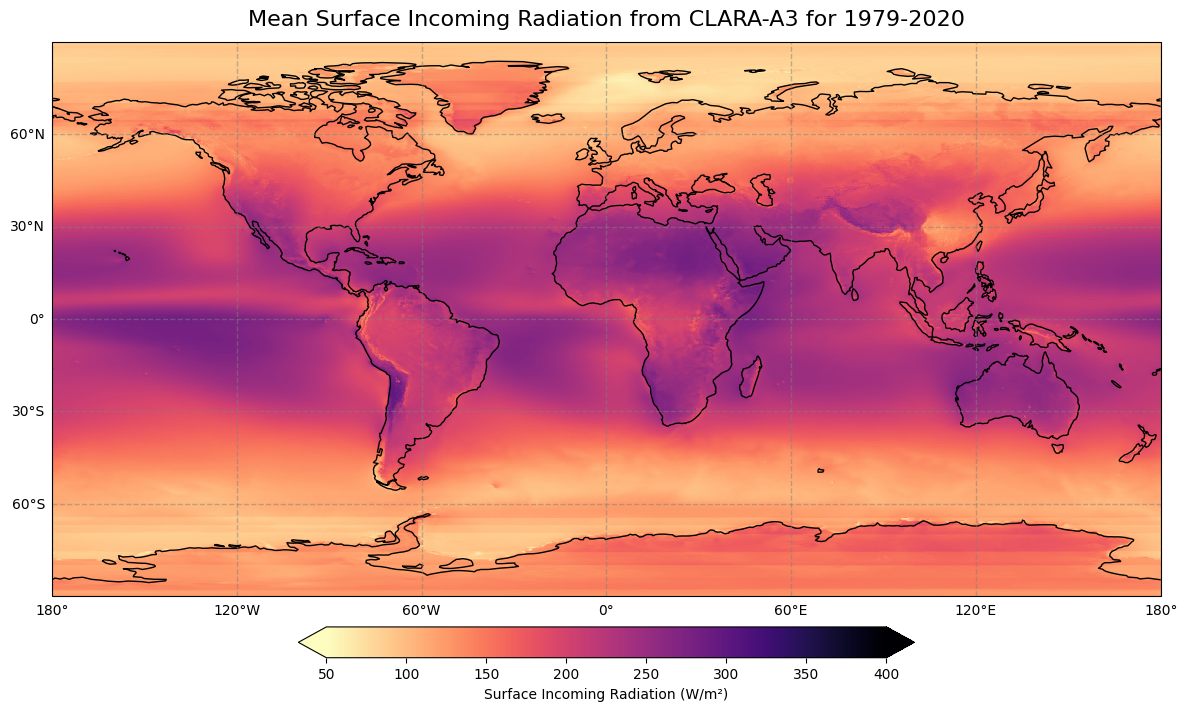

In [11]:
# Create figure and size
fig = plt.figure(figsize=(15, 8))

# Create the figure panel and define the Cartopy map projection (PlateCarree)
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

# Plot the data and set colorbar, minimum and maximum values
im = plt.pcolormesh(lon, lat, average, cmap='magma_r', vmin=50, vmax=400)

# Set title and size
ax.set_title('Mean Surface Incoming Radiation from CLARA-A3 for 1979-2020', fontsize=16, pad=12)

# Define gridlines with linewidth, color, opacity and style
gl = ax.gridlines(linewidth=1, color='gray', alpha=0.5, linestyle='--')

# Set x- and y-axis labels to True or False
gl.top_labels = False
gl.bottom_labels = True
gl.left_labels = True

# Set coastlines
ax.coastlines()

# Set colorbar and adjust size, location and text
cbar = plt.colorbar(im, fraction=0.05, pad=0.05, orientation='horizontal', extend='both')
cbar.set_label('Surface Incoming Radiation (W/m²)')

# Save figure in defined path and name
plt.savefig(FIGPATH + '/SISmm_mean.png')

# Show plot and close it afterwards to reduce the amount of storage
plt.show()
plt.close()

**Figure 1** shows the global mean values of the Surface Incoming Shortwave radiation (SIS). The highest values of Surface Incoming Radiation (SIS) are observed in the tropical regions and gradually decreasing towards the poles. There are however some irregularities. They are mostly caused by cloud coverage. So, the maximum values of SIS occur in the tropical and subtropical deserts (Sahara, Atacama, Namib deserts) and not at the equator where cloudy days are more common. Another example of high SIS values is the eastern parts of the tropical oceans, where trade winds cause a decrease in cloudiness (eastern parts of the Pacific and Atlantic oceans near the North American and African continents respectively). Monsoons in eastern and south-eastern Asia cause a decrease in the surface radiation as well. The sun does not rise above the horizon during the winter seasons in the Polar Regions, thus the annual averaged SIS values are the lowest there.

##  Use case 2: Relative Anomaly. Hot summer of the year 2003 in Europe

Please note that you need to open the dataset to be able to execute this usecase, as described in the previous section ["Load dataset"](#load).

The spatial resolution of the CLARA-A3 radiation dataset is 0.25ºx0.25º that is roughly equal to 25x25 km. With this resolution, it is possible to conduct a regional analysis using the CLARA-A3 radiation datasets. Furthermore, we can use the CLARA-A3 radiation datasets to investigate recent meteorological events. This could be a research project for a student or provide complementary information on a special event, e.g., the analysis of recent heat waves. In recent years, a high number of heat waves appeared in Europe. Particularly interesting is the summer 2003.

Firstly, we will select the data for year 2003 using `sel` argument.

Then, we split the SRB data according to the seasons by using the `groupby()` method, with `'time.season'` as an argument, and then averaged over the years. 
Seasons are defined as follows:
- Spring: March, April, May
- Summer: June, July, August
- Autumn: September, October, November
- Winter: December, January, February

In [12]:
# Select the 'JJA' season for the year 2003
jja_data_2003 = dataset_sis['SIS'].sel(time=slice('2003-06-01', '2003-08-31')).groupby('time.season').mean(dim='time')

# Calculate the climatology (average) for the 'JJA' season over all years
jja_climatology = dataset_sis['SIS'].groupby('time.season').mean(dim='time')

# Calculate the anomaly for the year 2003 by subtracting the climatology
anomaly_2003 = jja_data_2003 - jja_climatology

# Calculate the relative anomaly by dividing the anomaly by the climatology
relative_anomaly_2003 = anomaly_2003 / jja_climatology * 100

###  Plot of the relative anomaly in 2003 of SIS for Europe in relation to the temporal average of SIS

With the calculation done the data is ready for a plot. Please find the plot and settings in the next section.

Note: A warnung can occur due to nan's in the dataset and possible cases where a "divide by nan" happens. That can be ignored. 

/home/randbee/.local/lib/python3.10/site-packages/dask/core.py:133: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


/home/randbee/.local/lib/python3.10/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_cultural/ne_50m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


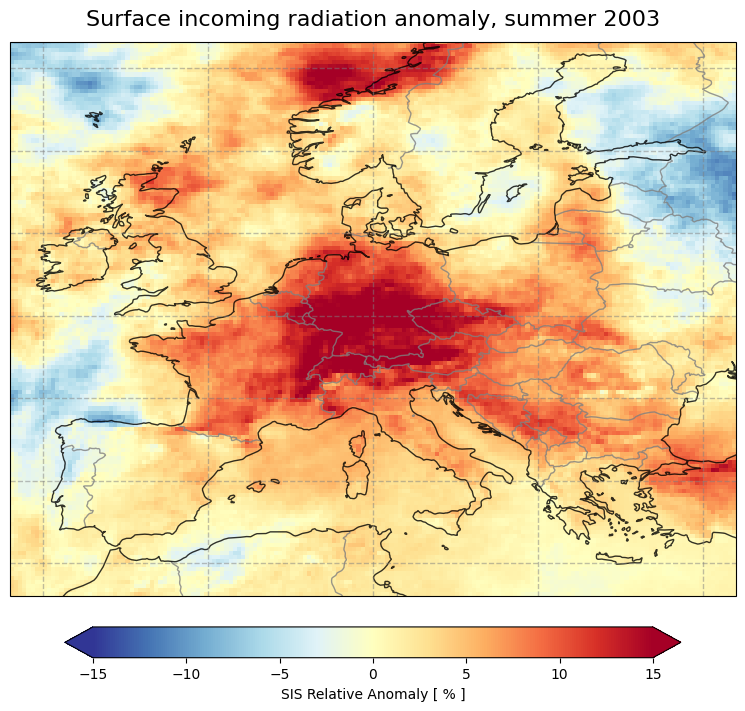

In [13]:
# Create figure and size
fig = plt.figure(figsize=(15, 8))

# Create the figure panel and define the Cartopy map projection (PlateCarree)
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

# Plot the data and set colorbar, minimum and maximum values
im = plt.pcolormesh(
    relative_anomaly_2003.lon,
    relative_anomaly_2003.lat,
    relative_anomaly_2003.sel(season='JJA'),
    vmin=-15,
    vmax=15,
    cmap='RdYlBu_r',
    transform=ccrs.PlateCarree()
)

# Only plot Europe
ax.set_extent([-12., 32., 33., 65.])

# Set title and size
ax.set_title('Surface incoming radiation anomaly, summer 2003', fontsize=16)

# Set x- and y-axis labels to True or False
gl.top_labels = False
gl.bottom_labels = True
gl.left_labels = True

# Define gridlines with linewidth, color, opacity and style
gl = ax.gridlines(linewidth=1, color='gray', alpha=0.5, linestyle='--')

# Add country borders, and coastlines.
ax.add_feature(cfeature.BORDERS, edgecolor='gray', alpha=0.8)
ax.coastlines(alpha=0.8)

# Add title
plt.title('Surface incoming radiation anomaly, summer 2003', fontsize=16, pad=12)

# Set colorbar and adjust size, location and text
cbar = plt.colorbar(im, ax=ax, fraction=0.05, pad=0.05, orientation='horizontal', extend='both')
cbar.set_label('SIS Relative Anomaly [ % ]')

# Save figure in defined path and name
plt.savefig(FIGPATH + '/SISmm_Anomaly2003.png')

**Figure 2** shows SIS relative anomaly for the summer 2003 (in relation of summer 1979-2020). The summer of 2003 was anomalously hot and dry with the most extreme heat wave in August. The unusually dry spring contributed to enhanced heating. Long-lasting anticyclones during the summer season caused clear-sky conditions and led to high surface radiative fluxes.

The heat wave mostly affected western and central Europe. In southern and central Germany, the difference (anomaly) to the mean climatological SIS values, were as high as 30 W/m2. The climatological mean SIS values for central Europe are 200 W/m2, this increase corresponds to a relative increase of 15%. European Mediterranean countries: Spain, France, Italy, Serbia, Greece and Turkey experienced SIS values 10-15 % higher than the climatological mean. At the same time, in the northern part of Europe, the summer was nice and warm.

The dry spring and hot summer had an effect on the crop yields throughout Europe. On the other hand, the ice-cream sales boomed. Also, winemakers praise 2003 as being exceptionally good for winemaking.

##  Get more information about Surface Radiation Budget

- [About 
Surface radiation budget from 1979 to present derived from satellite observations
](https://cds.climate.copernicus.eu/datasets/satellite-surface-radiation-budget?tab=overview)
- [About the Climate Data Store](https://cds.climate.copernicus.eu/)